<a href="https://colab.research.google.com/github/Ndaniel455/DataSciencePortfolios/blob/main/DTSA_5798_Supervised_Text_Classification_for_Marketing_Analytics_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Supervised Text Classification for Marketing Analytics Final Project

###Background of the Project:

Imagine you're working at a media buying company, Chrishare. They have a new client, Theragun. Your challenge now is to build a deep learning algorithm that predicts the probability that a news story is about health and wellness. You’ll be using the k-train, which is a wrapper for Tensorflow, Keras, and Huggingface Transformers

##Importing Librays

In the course of this project, my primary toolkit will revolve around [ktrain](https://github.com/amaiya/ktrain#installation). ktrain, an elegant utility, serves as a seamless extension to the TensorFlow Keras deep learning library (and other frameworks). Its purpose is to facilitate the construction, training, and deployment of neural networks and various machine learning models.



In [ ]:
import os
try:
  import ktrain
except:
  !pip install ktrain
  os.kill(os.getpid(), 9)
try:
  from pandas_profiling import ProfileReport
except:
  !pip install pandas-profiling
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from ktrain import text
import plotly.express as px
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Aug 13 18:19:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Gathering the Data
If you would like to run the project please download the file from the Kaggle website [here](https://www.kaggle.com/datasets/rmisra/news-category-dataset/versions/2?datasetId=32526&select=News_Category_Dataset_v3.json). Then save the `News_Category_Dataset_v3` into your google dive under the MyDrive folder. Do not change the name of the file.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###About the Data

The dataset encompasses a total of 210,294 records spanning the years from 2012 to 2022. Within each JSON record, the subsequent attributes are included:

- `Category`: The category to which the article pertains.
- `Headline`: The title of the article.
- `Authors`: The individuals responsible for authoring the article.
- `Link`: A direct link to the corresponding post.
- `Short Description`: A succinct overview of the article's content.
- `Date`: The publication date of the article.

In [ ]:
df = pd.read_json("drive/MyDrive/News_Category_Dataset_v3.json", lines=True)

Presenting an overview of the dataset's structure, unique categories, and fundamental article information.

In [ ]:
print(df.shape)
print("Unique categories:",df['category'].nunique())
print("-------------------------------------------------")
df.info()

(209527, 6)
Unique categories: 42
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


Displayed below is a succinct yet comprehensive overview of essential statistical metrics pertaining to the numerical attributes within our dataset.

In [ ]:
df.describe().style.set_properties(**{'background-color': '#F0F0F0',
                                    'color': '#222222',
                                    'border': '1.5px  solid black'})

,link,headline,category,short_description,authors,date
count,209527,209527,209527,209527,209527,209527
unique,209486,207996,42,187022,29169,3890
top,https://www.huffingtonpost.comhttps://www.washingtonpost.com/politics/divisions-within-gop-over-trumps-candidacy-are-growing/2016/02/28/97b16010-de3a-11e5-8d98-4b3d9215ade1_story.html,Sunday Roundup,POLITICS,,,2014-03-25 00:00:00
freq,2,90,35602,19712,37418,100
first,nan,nan,nan,nan,nan,2012-01-28 00:00:00
last,nan,nan,nan,nan,nan,2022-09-23 00:00:00


###Profiling Report of Dataset
In the following section, we are generating a comprehensive profiling report for our article dataset. This meticulously generated report encompasses a wealth of information, encompassing data types, summary statistics, instances of missing values, unique values, correlations, distributions, and more. This report plays a pivotal role in swiftly comprehending the dataset's intrinsic traits and pinpointing potential areas of concern.

In [ ]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

###Key Finding from Profile Report
1. The dataset encompasses a remarkable diversity of 41 distinct news article categories.
2. Within our dataset, 'Politics' emerges as the prevailing news category.
3. A total of 27,993 distinct authors have contributed their expertise to a myriad of news articles.
4. The length of headlines exhibits considerable variation, ranging up to 320 characters, with a median length hovering around 59 characters.
5. Descriptions demonstrate a similar trend, with a maximum length of 1,472 characters and a median length of approximately 120 characters.

###Visulizing the Data
Concluding this segment, we will delve into a visual representation in the form of a pie chart depicting the distribution of various article categories. This visualization serves to provide us with enhanced insights into the prevalence of the Healthy Living category within the dataset.

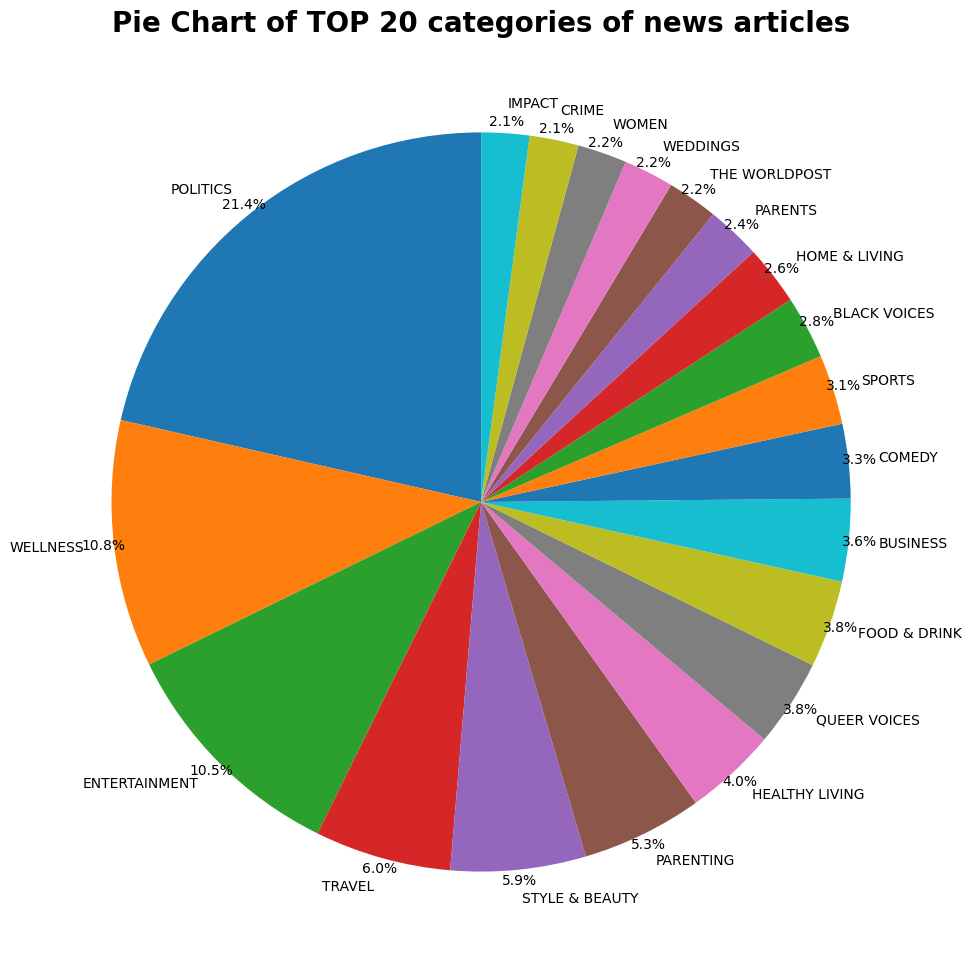

In [ ]:
#Creating new df with the counts of each category
cat_df = pd.DataFrame(df['category'].value_counts()).reset_index()
cat_df.rename(columns={'index':'news_classes','category':'numcat'}, inplace=True)

#Creating the pie chart - Limited to top 20 most common categories
fig = plt.figure(figsize=(12,12))
A = plt.pie(cat_df['numcat'][:20],
            labels=cat_df['news_classes'][:20],
            autopct='%1.1f%%',
            startangle=90,
            labeldistance=1.08,
            pctdistance=1.03,
            rotatelabels=False)

plt.title("Pie Chart of TOP 20 categories of news articles", size=20, weight='bold')
plt.show()

##Data Preprocessing
This project phase is dedicated to the meticulous data preparation necessary to conform to the specific requirements of the ktrain Deep Learning algorithm, a pivotal component of our analysis. By undertaking this crucial data preprocessing endeavor, we establish the groundwork for the subsequent stages of our investigation.

Recognizing the significance inherent in both the `headline` and `short_description` columns, we will undertake a concatenation of these columns into a singular entity. This imperative step stems from the prerequisite of our chosen machine learning tool, which solely accommodates a solitary input column.

In [ ]:
df['combined_text'] = df['headline'] + ' ' + df['short_description']
df[df['category'].str.contains("HEALTHY LIVING")]

,link,headline,category,short_description,authors,date,combined_text
16252,https://www.huffingtonpost.com/entry/to-the-pe...,To The People Who Say ‘I’m Tired’ When Someone...,HEALTHY LIVING,"When you feel like this, it’s important to kno...","The Mighty, ContributorWe face disability, dis...",2018-01-16,To The People Who Say ‘I’m Tired’ When Someone...
16367,https://www.huffingtonpost.com/entry/eating-sh...,Eating Shake Shack Made Me Feel Healthier Than...,HEALTHY LIVING,I can vividly remember the first time I felt f...,"Colleen Werner, ContributorCampus Editor-at-Large",2018-01-12,Eating Shake Shack Made Me Feel Healthier Than...
16421,https://www.huffingtonpost.com/entry/anxiety-f...,How To Stay Updated On The News Without Losing...,HEALTHY LIVING,Because it's only becoming more of a struggle.,Lindsay Holmes,2018-01-12,How To Stay Updated On The News Without Losing...
16601,https://www.huffingtonpost.com/entry/tweets-ab...,27 Perfect Tweets About Whole30 That Will Make...,HEALTHY LIVING,"""The only Whole30 I want to participate in is ...",Lindsay Holmes,2018-01-10,27 Perfect Tweets About Whole30 That Will Make...
16608,https://www.huffingtonpost.com/entry/the-real-...,The Real Reason Your Hands Are Always Cold,HEALTHY LIVING,"Essentially, your hands are kept warm thanks t...","Refinery29, ContributorThe #1 new-media brand ...",2018-01-10,The Real Reason Your Hands Are Always Cold Ess...
...,...,...,...,...,...,...,...
133587,https://www.huffingtonpost.com/entry/happy-hea...,Why You Need Both a 'Bouncer' and a 'Bartender...,HEALTHY LIVING,Instead of judging whether you made the right ...,"Elizabeth Grace Saunders, ContributorFounder, ...",2014-04-18,Why You Need Both a 'Bouncer' and a 'Bartender...
133588,https://www.huffingtonpost.com/entry/mental-il...,How Video Games Can Improve Dialogue on Mental...,HEALTHY LIVING,While there are strong arguments for the games...,"Mona Shattell, Contributornurse researcher",2014-04-18,How Video Games Can Improve Dialogue on Mental...
133599,https://www.huffingtonpost.com/entry/wake-up-c...,Wake-Up Calls Inspired My Change From Overdriv...,HEALTHY LIVING,My wake-up call marching orders were clear: No...,"Jane Shure, ContributorLeadership Coach, Psych...",2014-04-18,Wake-Up Calls Inspired My Change From Overdriv...
133624,https://www.huffingtonpost.com/entry/narcissis...,Loving a Narcissist Without Losing Yourself,HEALTHY LIVING,It is very difficult for some people to see an...,"Nancy Colier, ContributorPsychotherapist, inte...",2014-04-18,Loving a Narcissist Without Losing Yourself It...


Establishing a categorical attribute named "healthy" characterized by binary values 0 and 1. In this context, articles centered around healthy living are assigned the value 1, while those encompassing other topics receive the value 0.

In [ ]:
df['healthy'] = np.where((df['category'] == 'HEALTHY LIVING'), 1, 0)

Exploring essential statistical nuances encompassing percentiles, means, standard deviations, and related parameters.

In [ ]:
df['healthy'].describe()

count    209527.000000
mean          0.031948
std           0.175862
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: healthy, dtype: float64

Establishing a fresh DataFrame labeled as `df_count` to house the article counts pertaining to both the healthy living and non-healthy living categories. This meticulous approach is undertaken with the aim of ensuring a balanced distribution between the two article types. This balanced representation is pivotal, as an equitable distribution is essential to enable the algorithm to effectively discern articles centered around healthy living.

In [ ]:
df_count = df['healthy'].value_counts().reset_index()
df_count['index'] = df_count['index'].apply(lambda x: 'NOT HEALTHY LIVING' if x == 0 else 'HEALTHY LIVING')
df_count.rename(columns={'index': 'Category', 'healthy': 'Count'}, inplace=True)
df_count


,Category,Count
0,NOT HEALTHY LIVING,202833
1,HEALTHY LIVING,6694


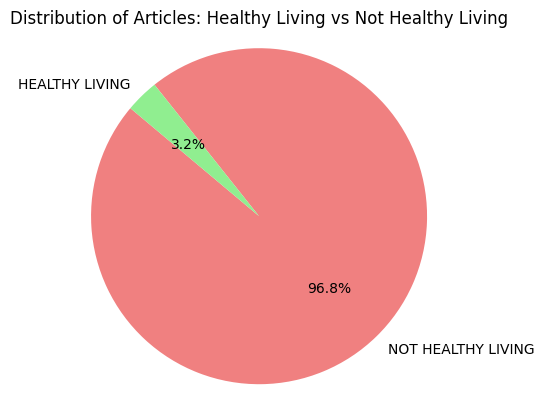

In [ ]:
labels = df_count['Category']
sizes = df_count['Count']
colors = ['lightcoral', 'lightgreen']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Distribution of Articles: Healthy Living vs Not Healthy Living')
plt.show()

The pie chart vividly illustrates that a substantial 96.8% of the articles do not pertain to healthy living. This stark imbalance could potentially hinder the algorithm's accuracy in discerning articles of this nature. To address this, our forthcoming step involves data rebalancing. This procedure entails a randomized selection of articles from the "Not Healthy Living" category to ensure parity in numbers.

In [ ]:
healthy_indices = df[df["healthy"] == 1].index
sample_amount = len(healthy_indices)
sampled_indices = random.sample(list(healthy_indices), sample_amount)
healthy = df.loc[sampled_indices]

not_healthy_indices = df[df["healthy"] == 0].index
sampled_indices = random.sample(list(not_healthy_indices), sample_amount)
not_healthy = df.loc[sampled_indices]

We must now consolidate the data from the `healthy` and `not_healthy` DataFrames into a single, cohesive DataFrame. From the descriptive statictics we can see that the mean is 0.5, signifying a balanced distribution between articles centered around health and those unrelated to health.

In [ ]:
df_sample = pd.concat([healthy, not_healthy])
df_sample.describe()

,healthy
count,13388.000000
mean,0.500000
std,0.500019
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


###Using Ktrain Preprocessing
One of the notable advantages of utilizing the `ktrain` package for our project is its comprehensive data preprocessing capabilities. When working with text data, preprocessing tasks such as tokenization, lowercasing, and special character handling are crucial to ensure that the data is in a format suitable for deep learning models. ktrain simplifies and streamlines this preprocessing phase by automating many of these tasks, alleviating the need for manual data cleaning.

##Building the Model
In this phase of the project, we construct and train a deep learning model using the ktrain package. Our journey begins with data preprocessing, where we leverage ktrain's capabilities to tokenize and standardize our text data. One key advantage lies in the automatic identification of an optimal learning rate using the lr_find function. This informed choice greatly influences the efficiency and effectiveness of our model training.

Armed with the ideal learning rate, we fine-tune a pre-trained bert model on our balanced dataset. This phase, a culmination of data-driven insights, empowers the model to discern patterns and relationships within textual content. As we traverse the model-building landscape, we embrace automation, insights, and a comprehensive evaluation process to equip ourselves with a potent model for our task.

###Streamlined Text Preparation and Data Splitting
n this stage of the project, we transition from data preprocessing to leveraging the potent `roberta-base` transformer model for text classification. By defining target class names as `NOT HEALTHY LIVING` and `HEALTHY LIVING`, we establish the fundamental categories for text categorization.

In [ ]:
target_names = ['NOT HEALTHY LIVING', 'HEALTHY LIVING']
t = text.Transformer('roberta-base', maxlen=512, class_names=target_names)

 the data is partitioned into training and testing sets to evaluate the model's performance. Utilizing the `train_test_split` function, the data from df_sample is divided into a training subset, which comprises 80% of the data, and a testing subset, with the remaining 20%. The division is achieved using a fixed random seed of 0, ensuring reproducibility.

In [ ]:
train, test = train_test_split(df_sample, test_size=0.2, random_state=0)
x_train = train['combined_text'].to_numpy()
y_train = train['healthy'].to_numpy()
x_test = test['combined_text'].to_numpy()
y_test = test['healthy'].to_numpy()

To prepare the training and validation data for the model, the `preprocess_train` and `preprocess_test` methods of the previously defined Transformer instance (`t`) are employed. The `preprocess_train` method takes in the training text data (`x_train`) and associated labels (`y_train`) to create a transformed representation suitable for training. Similarly, the `preprocess_test` method takes the testing text data (`x_test`) and labels (`y_test`) to generate the processed format for validation purposes. These two preprocessed datasets, trn for training and val for validation, are now ready to be utilized for training the model and assessing its performance. This preparation step ensures that the data is appropriately preprocessed and formatted for efficient model training and evaluation.

In [ ]:
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 29
	95percentile : 58
	99percentile : 70


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 29
	95percentile : 57
	99percentile : 71


###Creating and Training the Model
The model architecture is obtained by invoking the get_classifier method from the preprocessed transformer instance (t). This method prepares the underlying model structure based on the specified pre-trained transformer, in this case, "roberta-base".

The learner is created using the `get_learner` function from the `ktrain` library. This learner is initialized with the model, as well as the preprocessed training and validation data. The learner serves as a central component for model training, providing functions and utilities to fine-tune the model using the training data and monitor its performance on the validation set.

In [ ]:
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

The process of training is crucial as it fine-tunes the model's parameters to learn from the provided data. One key aspect of training is determining an appropriate learning rate, which dictates how much the model's weights are updated during each iteration. The `lr_find` method in this code aims to identify an optimal learning rate by performing a search across different learning rates while monitoring the corresponding loss changes.

In [ ]:
learner.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
1785/1785 [==============================] - 491s 263ms/step - loss: 0.5916 - accuracy: 0.6402
Epoch 2/6
1785/1785 [==============================] - 472s 263ms/step - loss: 0.3648 - accuracy: 0.8507
Epoch 3/6
1785/1785 [==============================] - 471s 263ms/step - loss: 0.6269 - accuracy: 0.5972
Epoch 4/6
1785/1785 [==============================] - 471s 263ms/step - loss: 1.2433 - accuracy: 0.4890
Epoch 5/6
1785/1785 [==============================] - 7s 3ms/step - loss: 1.6925 - accuracy: 0.5694


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


In this plot, we observe the relationship between the learning rate (on a logarithmic scale) and the associated loss. Our goal is to identify a distinct and rapid descent, indicative of the model learning rapidly while ensuring the loss remains within manageable bounds. The optimal learning rate for this model is around 1e-5. Armed with this insight, we can apply this learning rate to our model's training with confidence.

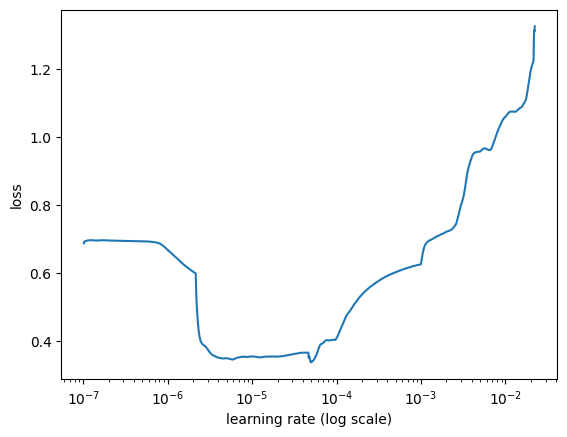

In [ ]:
learner.lr_plot()

We implement the model training process, leveraging the identified optimal learning rate of 1e-5. As the training unfolds over four epochs, we observe the model's evolution through a sequence of status updates. During each epoch, the model processes multiple batches of data, refining its predictive capabilities. The reported loss and accuracy metrics offer insights into the model's performance on both the training and validation sets. Gradually, we witness the loss metric decreasing, indicative of the model's growing competence in capturing the underlying patterns in the data. Simultaneously, the accuracy metric trends upwards, reflecting the model's improving ability to make accurate predictions. These observations affirm the effectiveness of the training process in enhancing the model's capacity to classify text data with heightened precision.

In [ ]:
identified_lr = 1e-5
learner.fit_onecycle(lr=identified_lr, epochs=4)



begin training using onecycle policy with max lr of 1e-05...
Epoch 1/4
1785/1785 [==============================] - 516s 278ms/step - loss: 0.4032 - accuracy: 0.8176 - val_loss: 0.3237 - val_accuracy: 0.8701
Epoch 2/4
1785/1785 [==============================] - 490s 274ms/step - loss: 0.2956 - accuracy: 0.8804 - val_loss: 0.3279 - val_accuracy: 0.8697
Epoch 3/4
1785/1785 [==============================] - 493s 276ms/step - loss: 0.2141 - accuracy: 0.9163 - val_loss: 0.3028 - val_accuracy: 0.8932
Epoch 4/4
1785/1785 [==============================] - 491s 275ms/step - loss: 0.1227 - accuracy: 0.9569 - val_loss: 0.3368 - val_accuracy: 0.8947


##Model Evaluation
After building and training our text classification model using the ktrain package, it is crucial to assess its performance and validate its effectiveness. In this section, we will delve into the various evaluation techniques employed to gauge the model's accuracy, robustness, and generalization capabilities.

In [ ]:
validation = learner.validate(val_data=val, print_report=True)

84/84 [==============================] - 17s 204ms/step
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      1356
           1       0.86      0.94      0.90      1322

    accuracy                           0.89      2678
   macro avg       0.90      0.90      0.89      2678
weighted avg       0.90      0.89      0.89      2678



###Classification Report and Confusion Matrix
The primary goal of our text classification model is to correctly assign articles to either the "Healthy Living" or "Not Healthy Living" category. To gain insight into the model's performance on individual classes, we analyze the classification report. This report provides essential metrics such as precision, recall, and F1-score, offering a comprehensive overview of our model's accuracy and ability to handle different class distributions. Complementing the classification report, we visualize the model's predictions using a confusion matrix. This matrix provides a clear depiction of true positives, true negatives, false positives, and false negatives, allowing us to understand where the model excels and where improvements might be necessary.

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=t)
y_pred = predictor.predict(x_test, return_proba=True)

In [ ]:
y_pred_classes = y_pred.argmax(axis=1)
class_report = classification_report(y_test, y_pred_classes, target_names=target_names)
print("Classification Report:\n", class_report)

Classification Report:
                     precision    recall  f1-score   support

NOT HEALTHY LIVING       0.94      0.85      0.89      1356
    HEALTHY LIVING       0.86      0.94      0.90      1322

          accuracy                           0.89      2678
         macro avg       0.90      0.90      0.89      2678
      weighted avg       0.90      0.89      0.89      2678



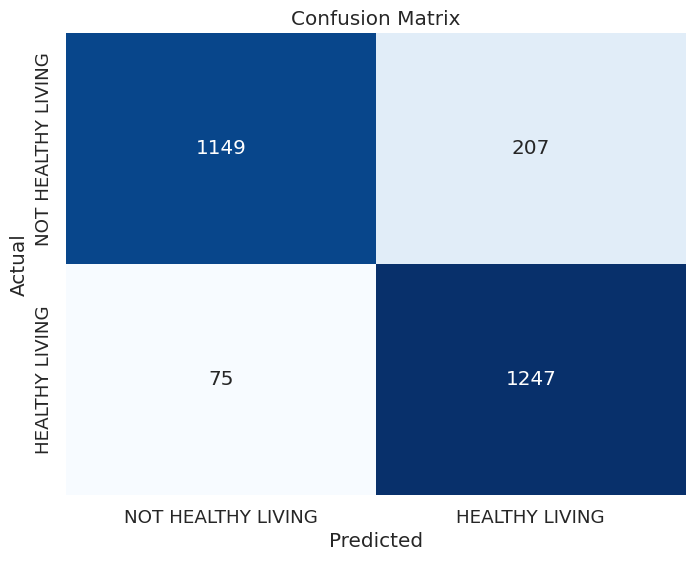

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

###ROC Curve and AUC Score
In binary text classification, assessing the model's ability to discriminate between the two classes is crucial. We employ the Receiver Operating Characteristic (ROC) curve and the corresponding Area Under the Curve (AUC) score. The ROC curve illustrates the trade-off between true positive rate and false positive rate at various classification thresholds. The AUC score summarizes the model's overall discriminatory power, providing a single metric to quantify its performance.


In [ ]:
# Calculate and print ROC AUC score
fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])
roc_auc = auc(fpr, tpr)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.9518060594700974


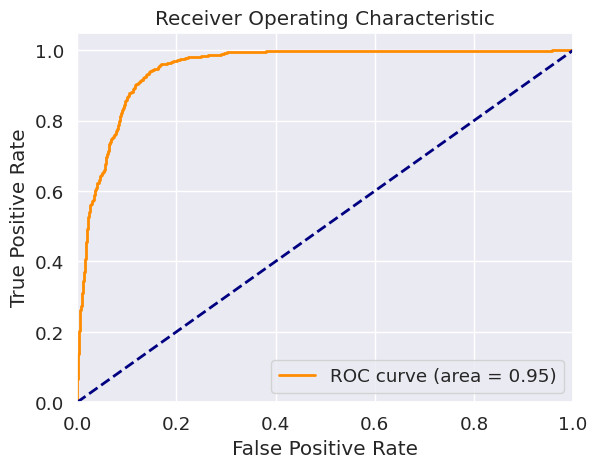

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

###Interpretability and Textual Evaluation
To gain further insights into our model's decision-making process, we manually inspect misclassified text samples. Analyzing these samples allows us to understand the challenges our model faces and provides directions for potential improvements. Additionally, we assess how well the model performs on real-world examples, enhancing our understanding of its practical utility.

In the subsequent sections, we will dive deeper into each evaluation technique, providing detailed analyses of our model's performance and drawing conclusions about its effectiveness in classifying text articles.

In [ ]:
test_docs = [
    # Healthy Topics
    'Maintaining a balanced diet and staying active are essential for a healthy lifestyle. Include plenty of fresh fruits and vegetables in your meals.',
    'Regular exercise, such as walking, jogging, or swimming, can improve cardiovascular health and boost your energy levels.',
    'Adequate sleep is crucial for overall well-being. Establish a consistent sleep schedule and create a comfortable sleep environment.',
    'Hydration is key to maintaining proper bodily functions. Drink water throughout the day to stay well-hydrated.',
    'Incorporating meditation and relaxation techniques into your routine can help reduce stress and promote mental clarity.',

    # Other Topics
    'The latest political developments are shaping the future of the country. Key decisions are being made that will impact the nation.',
    'Entertainment news is abuzz with rumors about upcoming movie releases and celebrity events. Fans are eagerly awaiting new content.',
    'Business leaders are strategizing to navigate the ever-changing market landscape. Innovation and adaptation are key to success.',
    'The stock market has seen significant fluctuations recently, driven by global economic trends. Investors are closely monitoring the situation.',
    'In the world of technology, advancements in artificial intelligence are paving the way for exciting new applications across industries.'
]

In [ ]:
for i, text in enumerate(test_docs):
  probs = predictor.predict(text, return_proba=True)
  print("---------------------------")
  print('The probability this is healthy is %s' % probs[1])
  print(text)

---------------------------
The probability this is healthy is 0.980853
Maintaining a balanced diet and staying active are essential for a healthy lifestyle. Include plenty of fresh fruits and vegetables in your meals.
---------------------------
The probability this is healthy is 0.970579
Regular exercise, such as walking, jogging, or swimming, can improve cardiovascular health and boost your energy levels.
---------------------------
The probability this is healthy is 0.9759232
Adequate sleep is crucial for overall well-being. Establish a consistent sleep schedule and create a comfortable sleep environment.
---------------------------
The probability this is healthy is 0.9898263
Hydration is key to maintaining proper bodily functions. Drink water throughout the day to stay well-hydrated.
---------------------------
The probability this is healthy is 0.9845241
Incorporating meditation and relaxation techniques into your routine can help reduce stress and promote mental clarity.
------